# Fine-Tuning BERT to Classify Megablunders 

## Introduction 

My high school teaches a set of eight grammatical errors known as Megablunders: pronoun reference (PR), sentence fragments (FRAG), pronoun case (CASE), dangling modifiers (DM), misplaced modifiers (MM), pronoun agreement (AGREE), run-on sentences (ROS), and parallelism (PAR). These errors are common in everyday writing, so I set out to build a model capable of identifying them with high accuracy—ideally matching human-level performance. This notebook documents the code used to train that model, which was run on Kaggle using a P100 GPU.


### Reproducibility 


This cell is designed to improve reproducibility by setting the random seeds for all the packages to 42. However the results will always retain a degree of randomness because of the dropout layers present in the model.

In [1]:
import random
import numpy as np
import torch
from transformers import set_seed

SEED = 42

# Set Python random seed
random.seed(SEED)

# Set NumPy random seed
np.random.seed(SEED)

# Set PyTorch seed
torch.manual_seed(SEED)

# Set seed for CUDA
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Ensure deterministic behavior in PyTorch (optional, but helpful)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set Hugging Face Transformers seed (Trainer-related randomness)
set_seed(SEED)

2025-06-28 00:18:05.589642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751069885.612928     952 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751069885.620010     952 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading and Processing Data

### Methodology 

The dataset I used for training consisted of about 180 human-written Megablunders and around 200 Megablunders generated with ChatGPT using GPT-4. GPT-4 grasped the concepts well when prompted with a few example sentences and general instructions. However, weak performance on CASE and AGREE errors was identified, and because of how similar those errors are, I hand-checked the generated sentences for those errors. The dataset is stored on Kaggle. 

### Loading

I loaded the dataset using the Hugging Face `dataset` library. 

In [2]:
import pandas as pd
from datasets import load_dataset

data = load_dataset("csv", data_files="../input/real-and-synthetic-megablunders/megablunders.csv")

In [3]:
print(data.column_names)

{'train': ['text', 'label']}


In [4]:
dataset = data["train"]

Available columns: ['text', 'label']
Example row: {'text': 'By dropping a game to the pathetic Tampa Bay Devil Rays, we may be on the verge of another Red Sox collapse.', 'label': 'DM'}
Class Distribution:
DM: 22
FRAG: 20
PR: 22
AGREE: 16
PAR: 22
CASE: 19
ROS: 22
NONE: 22
MM: 20


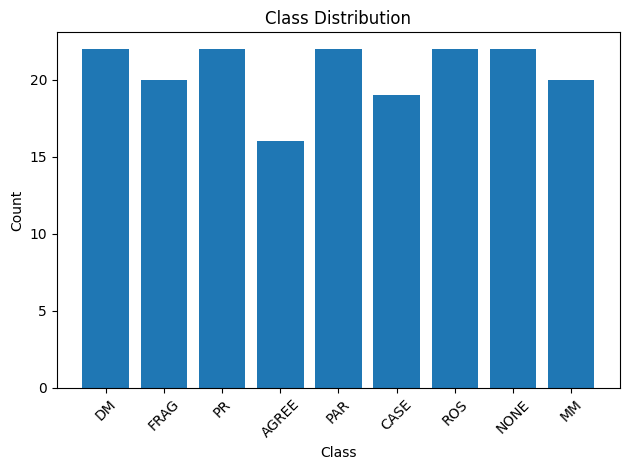

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

print("Available columns:", dataset.column_names)
print("Example row:", dataset[0])

label_column = "label"  # change if needed
labels = dataset[label_column] 

# Count labels
label_counts = Counter(labels)

# Map integer labels to names if available
if hasattr(dataset.features[label_column], "names"):
    label_names = dataset.features[label_column].names
    label_counts_named = {label_names[k]: v for k, v in label_counts.items()}
else:
    label_counts_named = label_counts

# Print class distribution
print("Class Distribution:")
for label, count in label_counts_named.items():
    print(f"{label}: {count}")

# Plot it
plt.bar(label_counts_named.keys(), label_counts_named.values())
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The class distribution is relatively balanced overall. However, the lower representation of CASE and AGREE errors may lead to performance issues later in training--such as poor generalization or misclassification--especially given how similar they are. 

In [6]:
data = load_dataset("csv", data_files="../input/real-and-synthetic-megablunders/megablunders.csv") # reload the data to prevent any errors from the investigation 

## Model Selection and Tokenization

For my model, I opted for [BERT](https://huggingface.co/google-bert/bert-base-uncased), a widely-used transformer model from Google pre-trained on English. I chose BERT because of its understanding of English without any pre-training. My decision to use a general-purpose BERT checkpoint was driven by simplicity and efficacy. I experimented with DistillBERT but found that performance was not as strong. 


### Tokenization

Tokenization is one of the most important aspects for performance. When I first started experimenting with LSTMs and decision trees, I found that choosing a reasonable tokenizer was tricky. The model was simply identifying grammatical errors, so techniques such as TF-IDF tokenization weren't ideal. However, it was after I switched to using BERT that I found using BERT as a tokenizer was highly effective and yielded much better results. 

Here, I use Hugging Face's `transformers` library to load the `google-bert/bert-base-uncased` model for tokenization. 


In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

The labels were label encoded. An issue that can occur when using label encoding is that it can introduce an artificial ordinal relationship. For example, PR errors could be represented by the number 1 and PAR errors with the number 2. However, in this case, the model treats the labels as categorical classes in a classification task, so the numerical values are used only as identifiers and do not affect model behavior.

In [8]:
label_list = ["AGREE", "DM", "MM", "ROS", "PR", "PAR", "FRAG", "CASE", "NONE"]
label_to_id = {label: i for i, label in enumerate(label_list)}

# one-hot encode the errors
def convert_labels(examples):
    examples["label"] = [label_to_id[label] for label in examples["label"]]
    return examples

# one-hot encode the whole dataset
data = data.map(convert_labels, batched=True)

# check the first couple rows
print(f"Converted labels: {data['train']['label'][:5]}")

Converted labels: [1, 6, 4, 0, 5]


In [9]:
# preview the data one last time before tokenization
data['train'][:5]

{'text': ['By dropping a game to the pathetic Tampa Bay Devil Rays, we may be on the verge of another Red Sox collapse.',
  'Although, if history is any indication, the tease could still go on for several weeks.',
  'The Sox almost never go down uneventfully, which is the most frustrating thing for their legion of fans.',
  'Because of the accumulated bad karma that hangs over the franchise, the skill of the players in any given year seem to be irrelevant to the outcome.',
  'The team not only has squandered huge leads but also it has come roaring from behind only to fall short.to fall short.'],
 'label': [1, 6, 4, 0, 5]}

Next, the dataset was tokenized using the BERT tokenizer. The tokenizer also applied padding and truncation to ensure that all the inputs were uniform. 

In [10]:
def tokenize(examples):
   return tokenizer(examples["text"], padding="max_length", truncation=True)

data = data.map(tokenize, batched=True)

## Training the Model

I started by loading the model, again using the `transformers` library. Since there are 9 Megablunders, i set the `num_labels` to 9.

In [11]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=9)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Metrics

Across the various runs, I found that one of the most important factors was the choice of evaluation metrics. While I started with accuracy, I quickly realized that it wasn't the most efficient alone. Combining it with precision guided better model adjustment, leading to a stronger performance on the final testing set. 

There is a key change to the precision metric in this code -- the average is set to macro, which weights each class equally. I chose this parameter because it helps add visibility into how the model performs across all classes, including the less frequent ones. By giving rare classes equal weight, macro-averaged precision exposed the weak spots that could've been easily overlooked. 


In [12]:
import evaluate
import numpy as np

acc_metric = evaluate.load("accuracy")
prec_metric = evaluate.load("precision")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
    prec = prec_metric.compute(
        predictions=preds, references=labels, average="macro", zero_division=0,
    )["precision"]

    return {"accuracy": acc, "precision": prec}

## Parameters

The learning rate for this task was set to 1e-5, lower than default. This learning rate was chosen to help the model converge more gradually instead of "skipping" over them. 200 training epochs were chosen because the model's loss metric continually decreased over the period without it taking excessively long to train.

In [13]:
from transformers import TrainingArguments

trainingArguments = TrainingArguments(
    output_dir="megablunders",
    save_total_limit=2,
    warmup_steps=19,
    num_train_epochs=200,
    learning_rate=1e-5,
    eval_strategy="epoch",
    report_to="none",
    push_to_hub=False,
    logging_steps=10, 
    logging_strategy="steps",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_precision",
    greater_is_better=True,
)

In [14]:
# switch the model to a cuda gpu if available 

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Training 

Now that the model is loaded onto the GPU and the parameters have been specified, all the properties can be passed to the Trainer object which will handle training the model.

In [ ]:
from transformers import Trainer
from datasets import DatasetDict

# Split the training data into train and test sets
train_test_split = data["train"].train_test_split(test_size=0.2, seed=42)
data = DatasetDict({
    "train": train_test_split["train"],
    "test": train_test_split["test"]
})

trainer = Trainer(
    model=model,
    args=trainingArguments,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision
1,2.225900,2.302943,0.081081,0.015152
2,2.080300,2.083206,0.324324,0.208333
3,2.035600,2.071393,0.216216,0.101705
4,1.895100,1.857328,0.405405,0.325298
5,1.884900,1.906017,0.351351,0.283139
6,1.774000,1.883948,0.324324,0.371032
7,1.665800,1.830318,0.405405,0.365645
8,1.590200,1.826168,0.405405,0.395644
9,1.504900,1.764480,0.459459,0.382711
10,1.437300,1.777159,0.486486,0.416947


## Evaluating the Model

For post-training evaluation, I chose to simply pass it through a couple of simple sentences as a sanity check. It did well on these examples, correctly identifying 4 of the 5 errors. 

In [ ]:
import torch
from transformers import BertTokenizer

test_examples = [
    "Because she was tired.",  # FRAG
    "Walking down the street, the dog was barking.",  # DM
    "I only ate pizza yesterday.",  # MM
    "Everyone should bring their own lunch.",  # PR
    "She likes swimming, running, and to bike.",  # PAR
    "Him and I went to the store.",  # CASE
    "The team are playing well.",  # AGREE
]

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize (note: passing list directly!)
inputs = tokenizer(test_examples, return_tensors="pt", truncation=True, padding=True)

# Get the model device
device = next(model.parameters()).device

# Move inputs to model's device
inputs = {key: val.to(device) for key, val in inputs.items()}

# Inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_ids = logits.argmax(dim=1).tolist()

# Label names (adjust if your labels differ)
label_list = ["AGREE", "DM", "MM", "ROS", "PR", "PAR", "FRAG", "CASE", "NONE"]

# Display predictions
for sentence, class_id in zip(test_examples, predicted_class_ids):
    print(f"{sentence} => {label_list[class_id]}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Because she was tired. => FRAG
Walking down the street, the dog was barking. => DM
I only ate pizza yesterday. => MM
Everyone should bring their own lunch. => DM
She likes swimming, running, and to bike. => MM
Him and I went to the store. => MM
The team are playing well. => CASE
Neither the mountain of unread submissions nor the myriad footnotes buried in the appendix have been reviewed by the editorial team despite multiple reminders circulated through internal memos and follow-up emails, each increasingly terse and exasperate => CASE


### Evaluating on Hard Megablunders 

I also ran the model through a couple of Isaac Wu's harder problems from his [Megablunder-Problem-Creator](https://github.com/isaacwu2000/Megablunder-Problem-Creator/blob/main/human_examples/medium.json) project. It correctly identified a few of the challenging errors, but the performance wasn't very strong. A confusion matrix is included in the results.

In [ ]:
from tabulate import tabulate
from sklearn.metrics import classification_report, confusion_matrix

hard_sentences = [
    "While the extent of this improvement that can be attributed to Trotsky is difficult to discern, especially when one considers that some improvement could be attributed to economic recovery from the Great War and the Russian Civil War as well as various other NEP policies because Trotsky created the unanimously approved four-stage plan, which guided economic policies during the NEP-era, and he advocated heavily for the electrification of Russia prior to his lackluster time as a director of the ETO, a significant portion of the improvement in power generation can be credited to Trotsky.",
    "The array of volatile variables, along with the coefficients derived from inconsistent models, suggest the conclusion remains unsubstantiated because neither the assumptions nor the results correspond consistently with empirical observations, which trouble the most experienced statisticians.",
    "Showcasing a rare Ming Dynasty manuscript—known for its thin brushstrokes and mulberry-bark paper fibers—the curator presented the masterpiece to a group of tourists who had been kept in airtight chambers for preservation.",
    "A carbon tax would generate significant funds amounting to nearly 125 million dollars; with the money generated from a carbon tax, the government should invest in social services: 10% of it should go to low-income households and the rest should go to the most pressing issues at the time of the carbon tax, which are currently the government deficit and a potential default.",
    "There is a common belief that pirates killed whoever they saw, but this belief is false.",
    "Leo believes that the average human is much more feeble than I.",
    "Once the memoir was released, with its fragmented prose and deliberately inconsistent chronology, it became clear that the audience would not respond uniformly, a response which frustrated reviewers who struggled to determine its purpose, they wondered whether it was meant to alienate.",
    "If I was in Ms. Tan's class and in your situation, I would ask the academic dean, who is very harsh, and Ms. Tan for an extension on the history paper.",
    "The pot boiling from the flames, the special potion was made by the evil witch despite the pot’s near bursting.",
    "Neither the mountain of unread submissions nor the myriad footnotes buried in the appendix have been reviewed by the editorial team despite multiple reminders circulated through internal memos and follow-up emails, each increasingly terse and exasperated.",
    "The violinist performed the final movement, wearing a sequined jacket once owned by a Hungarian virtuoso, to a jury of professors who had studied under Bartók and whose applause was hesitant.",
    "I know that you knew that I'm as wise as him."
]

hard_errors_correct = [
    "NONE",
    "AGREE",
    "MM",
    "PR",
    "CASE",
    "CASE",
    "NONE",
    "AGREE",
    "NONE",
    "AGREE",
    "MM",
    "CASE"
]

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize
inputs = tokenizer(hard_sentences, return_tensors="pt", truncation=True, padding=True)

# Get the model device
device = next(model.parameters()).device

# Move inputs to model's device
inputs = {key: val.to(device) for key, val in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_ids = logits.argmax(dim=1).tolist()

# Convert predictions to labels
predicted_labels = [label_list[i] for i in predicted_ids]

# Calculate accuracy
correct = sum(p == g for p, g in zip(predicted_labels, hard_errors_correct))
accuracy = correct / len(hard_errors_correct)

# Display predictions
results = list(zip(hard_sentences, predicted_labels, hard_errors_correct))
print(tabulate(results, headers=["Sentence", "Predicted", "Actual"], tablefmt="grid"))

# Classification report
print("\nClassification Report:")
print(classification_report(hard_errors_correct, predicted_labels, labels=label_list))

print(f"\nAccuracy on hard set: {accuracy:.2%}")

print("\nConfusion Matrix:")
print(confusion_matrix(hard_errors_correct, predicted_labels, labels=label_list))

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+----------+
| Sentence                                                                                                                                                                                                                                                                                                                                                                                 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

## Final Steps

Finally, I exported the model for the second part of my project: building a simple React app where the model can be used. 

In [ ]:
model.save_pretrained("./model")
tokenizer.save_pretrained("./tokenizer")

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.txt',
 './tokenizer/added_tokens.json')

Finally, I exported the model for the second part of my project: building a super simple React app where the model can be used. Overall, fine-tuning BERT yielded a decent model that can likely outperform some students or deliver similar results, especially on easy questions. With some more hyperparamater tuning and a more robust dataset, it could achieve a higher accuracy. Additionally, refining the model selection or even tokenization could improve performance.